In [1]:
import matplotlib.pyplot as plt
from keras import applications
from keras.preprocessing.image import ImageDataGenerator
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dropout, Flatten, Dense
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, Flatten
from keras import backend as K
import numpy as np 
import pandas as pd
import os
from sklearn.metrics import classification_report, confusion_matrix
import sklearn.metrics as metrics 
import sklearn
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt
%matplotlib inline           

Using TensorFlow backend.


In [2]:
# create the base pre-trained model
# build the VGG19 network
base_model = applications.VGG19(weights='imagenet', include_top=False, 
                                input_shape=(150,150,3))
print('Model loaded.')
base_model.summary()

W0215 20:49:58.230795 140433961994048 deprecation_wrapper.py:119] From /home/mlab/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0215 20:49:58.240654 140433961994048 deprecation_wrapper.py:119] From /home/mlab/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0215 20:49:58.242392 140433961994048 deprecation_wrapper.py:119] From /home/mlab/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0215 20:49:58.261255 140433961994048 deprecation_wrapper.py:119] From /home/mlab/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.



80142336/80134624 [==============================] - 2s 0us/step


W0215 20:50:01.102874 140433961994048 deprecation_wrapper.py:119] From /home/mlab/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0215 20:50:01.103497 140433961994048 deprecation_wrapper.py:119] From /home/mlab/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:181: The name tf.ConfigProto is deprecated. Please use tf.compat.v1.ConfigProto instead.



Model loaded.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0      

In [3]:
# this is the model we will train
model =Sequential()
model.add(base_model)
model.add(Flatten())
model.add(Dense(256,activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Model)                (None, 4, 4, 512)         20024384  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 22,122,049
Trainable params: 22,122,049
Non-trainable params: 0
_________________________________________________________________


In [4]:
print('Number of trainable weights before freezing: ', len(model.trainable_weights))
## to freesze all convolutional layers in pretrained network method 1
# base_model.trainable=False

Number of trainable weights before freezing:  36


In [5]:
# def recall_m(y_true, y_pred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred,0,1)))
#     possible_positives = K.sum(K.round(K.clip(y_true,0,1)))
#     recall = true_positives / (possible_positives + K.epsilon())
#     return recall
# def precision_m(y_true, ypred):
#     true_positives = K.sum(K.round(K.clip(y_true * y_pred,0,1)))
#     predicted_positives = K.sum(K.round(K.clip(y_pred,0,1)))
#     precision = true_positives/(predicted_positives+K.epsilon())
#     return precision 

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional pretrained layers method 2
for layer in base_model.layers:
    layer.trainable = False
print('After freezing: ', len(model.trainable_weights))
# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer=optimizers.Adam(lr=1e-4),metrics=['acc'], loss='binary_crossentropy')


W0215 20:50:01.589701 140433961994048 deprecation_wrapper.py:119] From /home/mlab/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0215 20:50:01.596862 140433961994048 deprecation.py:323] From /home/mlab/anaconda3/lib/python3.7/site-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


After freezing:  4


In [6]:
train_data_dir = '/home/mlab/Documents/brats_hl_data/train'
validation_data_dir = '/home/mlab/Documents/brats_hl_data/val'
# 44938
# 5616
nb_train_samples = 44938
nb_validation_samples = 5616
epochs = 8
batch_size = 32
# prepare data augmentation configuration
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='binary')

Found 44938 images belonging to 2 classes.
Found 5616 images belonging to 2 classes.


In [7]:
true_classes = train_generator.classes
print(true_classes)
class_labels = list(train_generator.class_indices.keys())
print(class_labels)

[0 0 0 ... 1 1 1]
['high', 'low']


In [8]:
# train the model on the new data for a few epochs
history =model.fit_generator(train_generator,
                             steps_per_epoch=nb_train_samples//batch_size,
                             epochs=epochs,
                             validation_data=validation_generator,
                             validation_steps=nb_validation_samples//batch_size)

Epoch 1/8
351/351 [==============================] - 1702s 5s/step - loss: 0.5645 - acc: 0.6924 - val_loss: 0.5497 - val_acc: 0.6989
Epoch 2/8
351/351 [==============================] - 1655s 5s/step - loss: 0.4993 - acc: 0.7454 - val_loss: 0.4647 - val_acc: 0.7611
Epoch 3/8
351/351 [==============================] - 1654s 5s/step - loss: 0.4677 - acc: 0.7682 - val_loss: 0.4392 - val_acc: 0.7804
Epoch 4/8
351/351 [==============================] - 1654s 5s/step - loss: 0.4455 - acc: 0.7829 - val_loss: 0.4782 - val_acc: 0.7458
Epoch 5/8
351/351 [==============================] - 1655s 5s/step - loss: 0.4265 - acc: 0.7959 - val_loss: 0.4318 - val_acc: 0.7793
Epoch 6/8
351/351 [==============================] - 1654s 5s/step - loss: 0.4104 - acc: 0.8041 - val_loss: 0.3962 - val_acc: 0.8141
Epoch 7/8
351/351 [==============================] - 1655s 5s/step - loss: 0.3992 - acc: 0.8116 - val_loss: 0.3884 - val_acc: 0.8103
Epoch 8/8
351/351 [==============================] - 1654s 5s/step - 

In [9]:
true_classes_1 = validation_generator.classes
print(true_classes)
class_labels_1 = list(validation_generator.class_indices.keys())
print(class_labels_1)

[0 0 0 ... 1 1 1]
['high', 'low']


In [10]:
#Confution Matrix and Classification Report
Y_pred = model.predict_generator(validation_generator, nb_validation_samples // batch_size+1)


In [11]:
# y_pred = np.argmax(Y_pred, axis=1)
y_pred = (Y_pred<0.475).astype(np.int)

# print('Confusion Matrix')
# print(confusion_matrix(true_classes_1, y_pred))
# print('Classification Report')
# print(classification_report(validation_generator.classes, y_pred, 
#                             target_names=class_labels_1))


In [12]:
# print(validation_generator.classes)

In [13]:
confusion_matrix = metrics.confusion_matrix(true_classes_1,y_pred)
print(confusion_matrix)

[[1624 1151]
 [1675 1166]]


In [14]:
report= sklearn.metrics.classification_report(true_classes_1, y_pred, 
                                              target_names = class_labels_1)
print(report)

              precision    recall  f1-score   support

        high       0.49      0.59      0.53      2775
         low       0.50      0.41      0.45      2841

   micro avg       0.50      0.50      0.50      5616
   macro avg       0.50      0.50      0.49      5616
weighted avg       0.50      0.50      0.49      5616



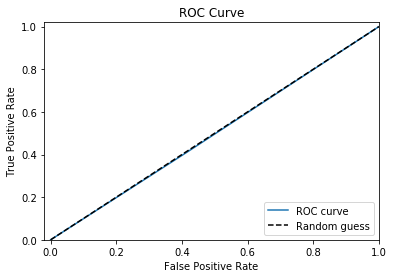

In [15]:
fpr, tpr, thresholds = roc_curve(validation_generator.classes, y_pred)

# create plot
plt.plot(fpr, tpr, label='ROC curve')
plt.plot([0, 1], [0, 1], 'k--', label='Random guess')
_ = plt.xlabel('False Positive Rate')
_ = plt.ylabel('True Positive Rate')
_ = plt.title('ROC Curve')
_ = plt.xlim([-0.02, 1])
_ = plt.ylim([0, 1.02])
_ = plt.legend(loc="lower right")

In [16]:
roc_auc_score(validation_generator.classes, y_pred)

0.4978220459107471

In [17]:
batchX, batchy = train_generator.next()
_, accuracy = model.evaluate(batchX, batchy)
print('Accuracy training: %.2f' % (accuracy*100))
batchXv, batchyv = validation_generator.next()
_, accuracy = model.evaluate(batchXv, batchyv)
print('Accuracy val: %.2f' % (accuracy*100))

128/128 [==============================] - 4s 32ms/step
Accuracy training: 83.59
128/128 [==============================] - 4s 32ms/step
Accuracy val: 80.47


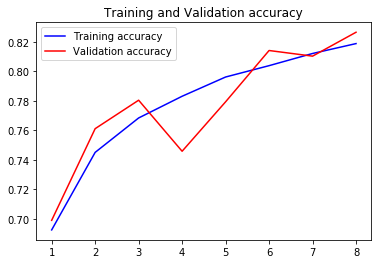

In [18]:
#plot the train and val curve
#get the details from the history object
acc = history.history['acc']
val_acc=history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1,len(acc)+1)

#train and validation accuracy
plt.plot(epochs,acc,'b',label='Training accuracy')
plt.plot(epochs,val_acc,'r',label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

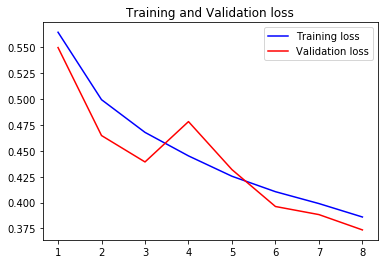

In [19]:
#train and validation loss
plt.plot(epochs, loss, 'b',label='Training loss')
plt.plot(epochs, val_loss, 'r',label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [20]:
test_generator = test_datagen.flow_from_directory('/home/mlab/Documents/brats_hl_data/test', 
                                      class_mode='binary', 
                                      batch_size=batch_size, 
                                      target_size=(150,150))
scores = model.evaluate_generator(test_generator, steps=nb_validation_samples//batch_size)

Found 5619 images belonging to 2 classes.


In [21]:
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 81.89%


In [22]:
#Confution Matrix and Classification Report
# Y_pred = model.predict_generator(val_generator, 5616 // batch_size)
nb_test_samples=5619
Y_pred1 = model.predict_generator(test_generator,nb_test_samples//batch_size+1)
# y_pred = np.argmax(Y_pred,axis=1)

In [23]:
true_classes_2 = test_generator.classes
print(true_classes_2)
class_labels_2 = list(test_generator.class_indices.keys())
print(class_labels_2)

[0 0 0 ... 1 1 1]
['high', 'low']


In [24]:
# y_pred1 = (Y_pred1<0.5).astype(np.int)
y_pred1 = (Y_pred1 < 0.475).astype(np.int)
# print(y_pred)
# print('Confusion Matrix')
# print(confusion_matrix(true_classes_2, y_pred1))
# print('Classification Report')
# print(classification_report(true_classes_2, y_pred1, target_names=class_labels_2))


In [25]:
confusion_matrix1 = metrics.confusion_matrix(true_classes_2,y_pred1)
print(confusion_matrix1)

[[1638 1138]
 [1666 1177]]


In [26]:
report1= sklearn.metrics.classification_report(true_classes_2, y_pred1, 
                                               target_names = class_labels_2)
print(report1)

              precision    recall  f1-score   support

        high       0.50      0.59      0.54      2776
         low       0.51      0.41      0.46      2843

   micro avg       0.50      0.50      0.50      5619
   macro avg       0.50      0.50      0.50      5619
weighted avg       0.50      0.50      0.50      5619



In [27]:
print(" Loss: ", scores[0],"\n","Accuracy: ", scores[1])

 Loss:  0.3795007598954578 
 Accuracy:  0.818859011627907
